In [1]:
# extra analysis for supplmental figure and fig 4 and 5

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import linregress
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
from sklearn.model_selection import ShuffleSplit, LeaveOneOut
from brainspace.gradient import GradientMaps

### Setting path

In [4]:
# Set this to your git-repo path for running the analyses.
main_path = "/srv/khan/users/sudesnac/00_Projects/HumanBF-Connectivity"

In [5]:
# Setting other paths
data_path = main_path + "/data/"
results_path = main_path + "/results/extra_analysis/"
fig_path = main_path + "/results/extra_analysis/figures/"

In [6]:
Func_results = main_path + "/results/Func_gradients/"
Diff_results = main_path + "/results/Diff_gradients/"
Gradc_results = main_path + "/results/gradient_correlation/"
Conn_results = main_path + "/results/connectivity_distance/"

### Supplemental Figure 2

In [7]:
# Load residuals
resid_results = pd.read_csv(Gradc_results + 'Struct_vs_Func_linear_least-squares_regression_s6-f4_residuals_statsmodels.csv')

In [8]:
# Squared 
resid_squared = resid_results**2

In [9]:
# Extract unweighted average and sg1-fg1 residuals
unweighted_avg_resid_squared = np.nanmean(resid_squared.values, axis=1)
sg1_fg1_resid_squared        = resid_squared[resid_squared.columns[0]].values

In [10]:
# Pearson's correlation
corr = linregress(sg1_fg1_resid_squared, unweighted_avg_resid_squared)
print(corr)

LinregressResult(slope=0.1993599689267975, intercept=0.0031768639201613046, rvalue=0.918104164701181, pvalue=3.951341853013897e-242, stderr=0.0035222958969123455, intercept_stderr=9.842016869870291e-05)


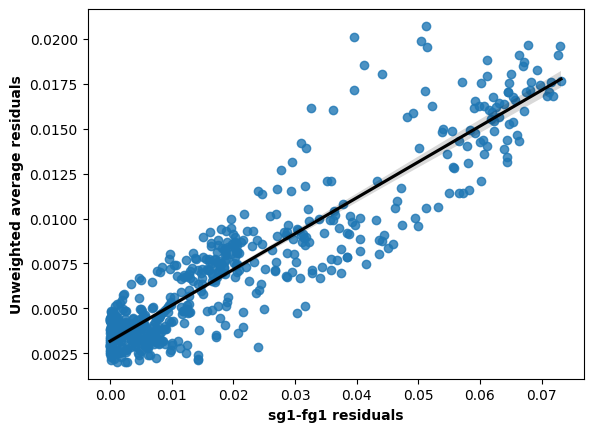

In [11]:
# Plot correlation
sc = sns.regplot(
    x=sg1_fg1_resid_squared,
    y=unweighted_avg_resid_squared,
    line_kws={'color': 'black'}
)

sc.set_xlabel('sg1-fg1 residuals', weight='bold')
sc.set_ylabel('Unweighted average residuals', weight='bold')

plt.savefig(fig_path + f'Unweighted-average_vs_sg1-fg1_residuals-corr.png', dpi=300, bbox_inches='tight')
plt.show()

### Supplemental Figure 3 (two groups)

#### Structural

In [12]:
# Load data
# data_path = '/project/6050199/sudesnac/21_Codes/HumanBF-Parcellation/data'
dmri_data = np.load(data_path + 'tpl-MNI152NLin6Asym_label-fullBF_desc-concat_from-7Tgroup_connMap.npz')

In [13]:
# Correlation matrix
dmri_correlation = dmri_data['conn_group']
dmri_avg_correlation = np.nanmean(dmri_correlation, axis=0)
dmri_avg_correlation += 1

In [14]:
# Define split between 'train' and 'test'
n_splits = 100 # should be something like 1000-5000
rs       = ShuffleSplit(n_splits=n_splits, test_size=.5, random_state=0)
X        = np.zeros((dmri_correlation.shape[0],1))

In [15]:
dmri_g_train_vals = []
dmri_g_test_vals  = []
dmri_corr_vals    = []

for i, (train_index, test_index) in enumerate(rs.split(X)):    
    # Train dataset average
    dmri_train_avg_correlation = np.nanmean(dmri_correlation[train_index,:,:], axis=0)
    
    # Train dataset average
    dmri_test_avg_correlation = np.nanmean(dmri_correlation[test_index,:,:], axis=0)
    
    # Compute principal gradient, with Procrustus alignment to average across all subjects
    dmri_gp_train = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    dmri_gp_train.fit([dmri_avg_correlation, dmri_train_avg_correlation])
    dmri_g_train_vals.append(dmri_gp_train.aligned_[1][:,0])
    
    # Now for test dataset
    dmri_gp_test = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    dmri_gp_test.fit([dmri_avg_correlation, dmri_test_avg_correlation])
    dmri_g_test_vals.append(dmri_gp_test.aligned_[1][:,0])
    
    # Pearson's correlation
    # Change to Spearman
    corr = linregress(dmri_gp_train.aligned_[1][:,0], dmri_gp_test.aligned_[1][:,0])
    dmri_corr_vals.append(corr.rvalue)

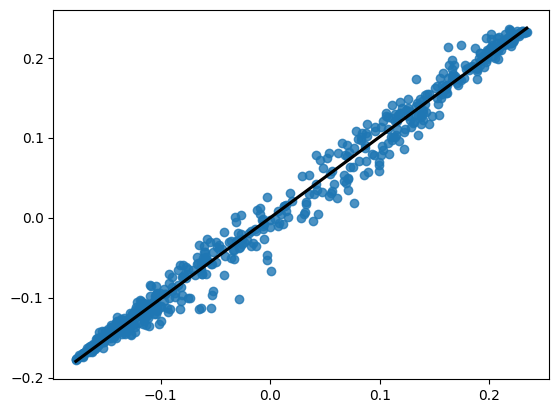

In [18]:
# Plot correlation
sc = sns.regplot(
    x=dmri_gp_train.aligned_[1],
    y=dmri_gp_test.aligned_[1],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'dMRI_split-half_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


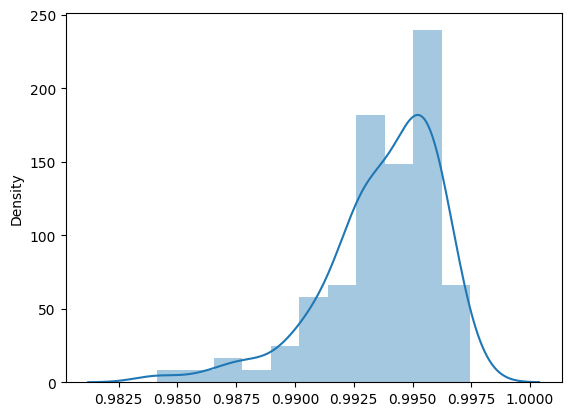

In [19]:
sns.distplot(dmri_corr_vals)
plt.savefig(fig_path + f'dMRI_split-half_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Functional

In [20]:
# Load data
#data_path = '/project/6050199/sudesnac/21_Codes/HumanBF-Parcellation/data'
fmri_data = np.load(data_path + 'correlation_matrix_HCP-MMP_group.npz')

In [21]:
# Correlation matrix
fmri_correlation     = fmri_data['corr_group']
indices              = fmri_data['indices']
fmri_avg_correlation = np.nanmean(fmri_correlation, axis=0)
fmri_avg_correlation += 1

In [22]:
fmri_g_train_vals = []
fmri_g_test_vals  = []
fmri_corr_vals    = []

# Use same splits as for the structural data
for i, (train_index, test_index) in enumerate(rs.split(X)):    
    # Train dataset average
    fmri_train_avg_correlation = np.nanmean(fmri_correlation[train_index,:,:], axis=0)
    
    # Train dataset average
    fmri_test_avg_correlation = np.nanmean(fmri_correlation[test_index,:,:], axis=0)
    
    # Compute principal gradient, with Procrustus alignment to average across all subjects
    fmri_gp_train = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    fmri_gp_train.fit([fmri_avg_correlation, fmri_train_avg_correlation])
    fmri_g_train_vals.append(fmri_gp_train.aligned_[1][:,0])
    
    # Now for test dataset
    fmri_gp_test = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    fmri_gp_test.fit([fmri_avg_correlation, fmri_test_avg_correlation])
    fmri_g_test_vals.append(fmri_gp_test.aligned_[1][:,0])
    
    # Pearson's correlation
    corr = linregress(fmri_gp_train.aligned_[1][:,0], fmri_gp_test.aligned_[1][:,0])
    fmri_corr_vals.append(corr.rvalue)

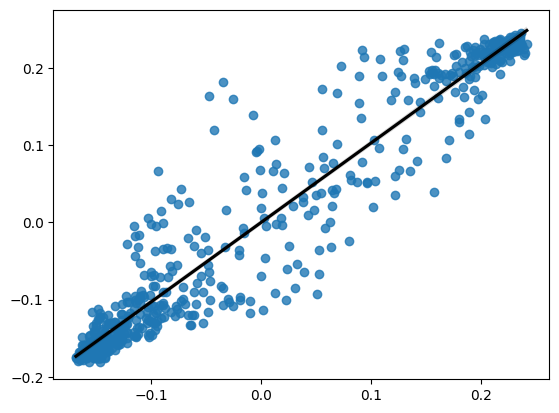

In [23]:
# Plot correlation
sc = sns.regplot(
    x=fmri_gp_train.aligned_[1],
    y=fmri_gp_test.aligned_[1],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'rsfMRI_split-half_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


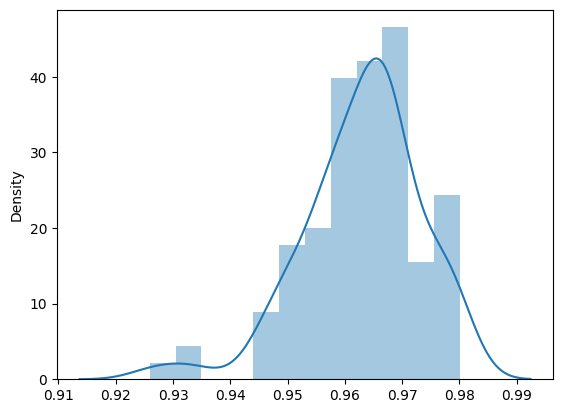

In [24]:
sns.distplot(fmri_corr_vals)
plt.savefig(fig_path + f'rsfMRI_split-half_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Residuals

In [25]:
resid_train_vals = []
resid_test_vals  = []
resid_corr_vals  = []

# Calculate residuals
for i in range(n_splits):    

    # Train
    model = sm.OLS(
        dmri_g_train_vals[i],
        fmri_g_train_vals[i]
    )
    train_results = model.fit()
    resid_train_vals.append(train_results.resid)

    # Test
    model = sm.OLS(
        dmri_g_test_vals[i],
        fmri_g_test_vals[i]
    )
    test_results = model.fit()    
    resid_test_vals.append(test_results.resid)

    # Pearson's correlation
    corr = linregress(train_results.resid, test_results.resid)
    resid_corr_vals.append(corr.rvalue)

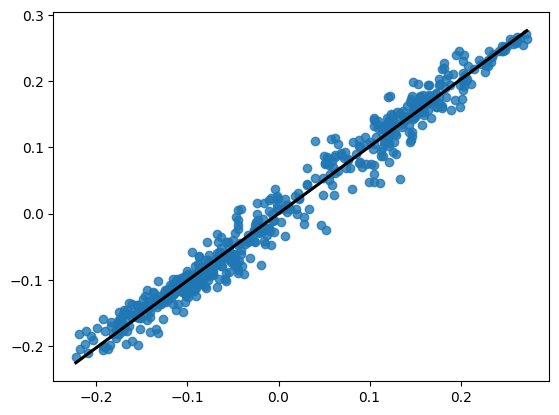

In [26]:
# Plot correlation
sc = sns.regplot(
    x=resid_train_vals[0],
    y=resid_test_vals[0],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'Residuals_split-half_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


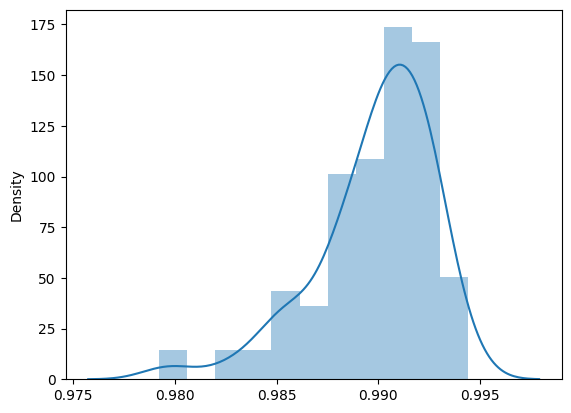

In [27]:
sns.distplot(resid_corr_vals)
plt.savefig(fig_path + f'Residuals_split-half_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Supplemental Figure 3 (leave one out)

#### Structural

In [28]:
# Define splits
loo      = LeaveOneOut()
X        = np.zeros((dmri_correlation.shape[0],1))
n_splits = loo.get_n_splits(X)

In [29]:
dmri_g_train_loo_vals = []
dmri_g_test_loo_vals  = []
dmri_corr_loo_vals    = []

for i, (train_index, test_index) in enumerate(loo.split(X)):    
    # Train dataset average
    dmri_train_avg_correlation = np.nanmean(dmri_correlation[train_index,:,:], axis=0)
    
    # Train dataset average
    dmri_test_avg_correlation = np.nanmean(dmri_correlation[test_index,:,:], axis=0)
    
    # Compute principal gradient, with Procrustus alignment to average across all subjects
    dmri_gp_train = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    dmri_gp_train.fit([dmri_avg_correlation, dmri_train_avg_correlation])
    dmri_g_train_loo_vals.append(dmri_gp_train.aligned_[1][:,0])
    
    # Now for test dataset
    dmri_gp_test = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    dmri_gp_test.fit([dmri_avg_correlation, dmri_test_avg_correlation])
    dmri_g_test_loo_vals.append(dmri_gp_test.aligned_[1][:,0])
    
    # Pearson's correlation
    # Change to Spearman
    corr = linregress(dmri_gp_train.aligned_[1][:,0], dmri_gp_test.aligned_[1][:,0])
    dmri_corr_loo_vals.append(corr.rvalue)

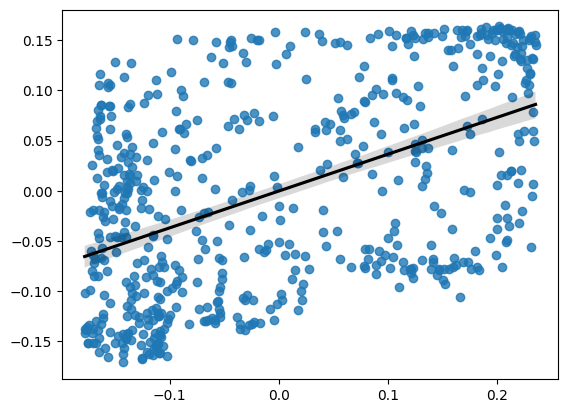

In [30]:
# Plot correlation
sc = sns.regplot(
    x=dmri_gp_train.aligned_[1],
    y=dmri_gp_test.aligned_[1],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'dMRI_leave-one-out_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


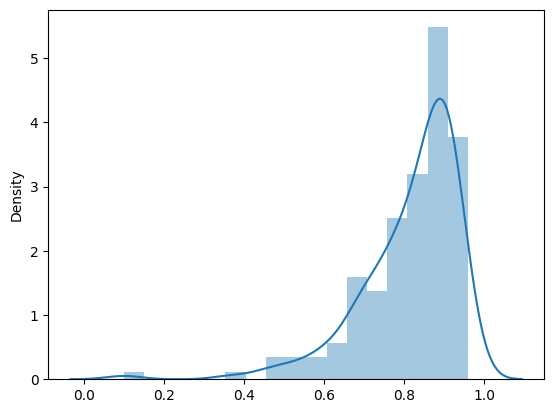

In [31]:
sns.distplot(dmri_corr_loo_vals)
plt.savefig(fig_path + f'dMRI_leave-one-out_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Functional

In [32]:
fmri_g_train_loo_vals = []
fmri_g_test_loo_vals  = []
fmri_corr_loo_vals    = []

# Use same splits as for the structural data
for i, (train_index, test_index) in enumerate(loo.split(X)):    
    # Train dataset average
    fmri_train_avg_correlation = np.nanmean(fmri_correlation[train_index,:,:], axis=0)
    
    # Train dataset average
    fmri_test_avg_correlation = np.nanmean(fmri_correlation[test_index,:,:], axis=0)
    
    # Compute principal gradient, with Procrustus alignment to average across all subjects
    fmri_gp_train = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    fmri_gp_train.fit([fmri_avg_correlation, fmri_train_avg_correlation])
    fmri_g_train_loo_vals.append(fmri_gp_train.aligned_[1][:,0])
    
    # Now for test dataset
    fmri_gp_test = GradientMaps(
        n_components=1, 
        kernel='normalized_angle',
        approach='dm',
        alignment='procrustes',
        random_state=0
    )
    fmri_gp_test.fit([fmri_avg_correlation, fmri_test_avg_correlation])
    fmri_g_test_loo_vals.append(fmri_gp_test.aligned_[1][:,0])
    
    # Pearson's correlation
    corr = linregress(fmri_gp_train.aligned_[1][:,0], fmri_gp_test.aligned_[1][:,0])
    fmri_corr_loo_vals.append(corr.rvalue)

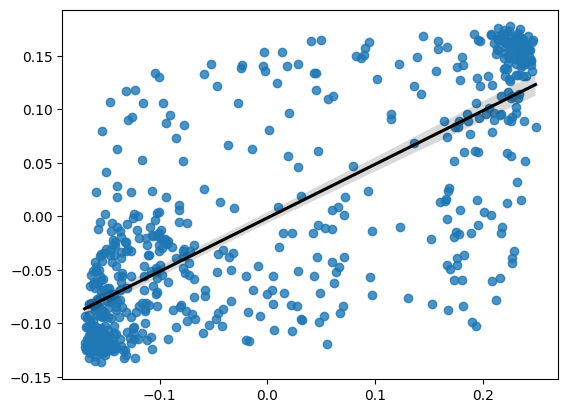

In [33]:
# Plot correlation
sc = sns.regplot(
    x=fmri_gp_train.aligned_[1],
    y=fmri_gp_test.aligned_[1],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'rsfMRI_leave-one-out_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


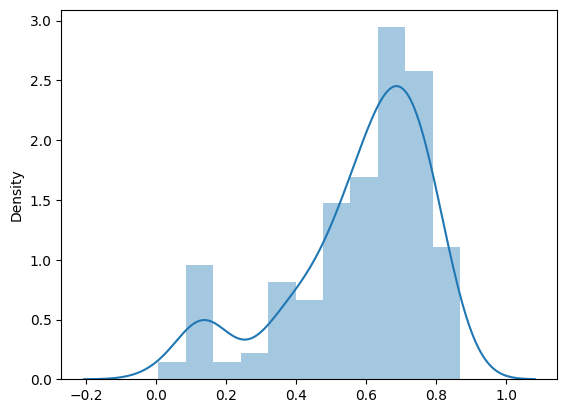

In [34]:
sns.distplot(fmri_corr_loo_vals)
plt.savefig(fig_path + f'rsfMRI_leave-one-out_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Residuals

In [35]:
resid_train_loo_vals = []
resid_test_loo_vals  = []
resid_corr_loo_vals  = []

# Calculate residuals
for i in range(n_splits):    

    # Train
    model = sm.OLS(
        dmri_g_train_loo_vals[i],
        fmri_g_train_loo_vals[i]
    )
    train_results = model.fit()
    resid_train_loo_vals.append(train_results.resid)

    # Test
    model = sm.OLS(
        dmri_g_test_loo_vals[i],
        fmri_g_test_loo_vals[i]
    )
    test_results = model.fit()    
    resid_test_loo_vals.append(test_results.resid)

    # Pearson's correlation
    corr = linregress(train_results.resid, test_results.resid)
    resid_corr_loo_vals.append(corr.rvalue)

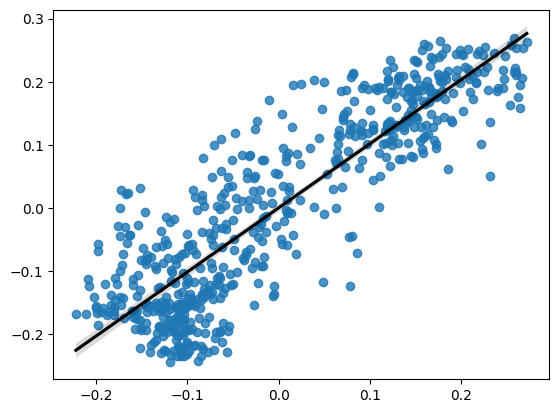

In [36]:
# Plot correlation
sc = sns.regplot(
    x=resid_train_loo_vals[0],
    y=resid_test_loo_vals[0],
    line_kws={'color': 'black'}
)
plt.savefig(fig_path + f'Residuals_leave-one-out_scatter-plot.png', dpi=300, bbox_inches='tight')
plt.show()

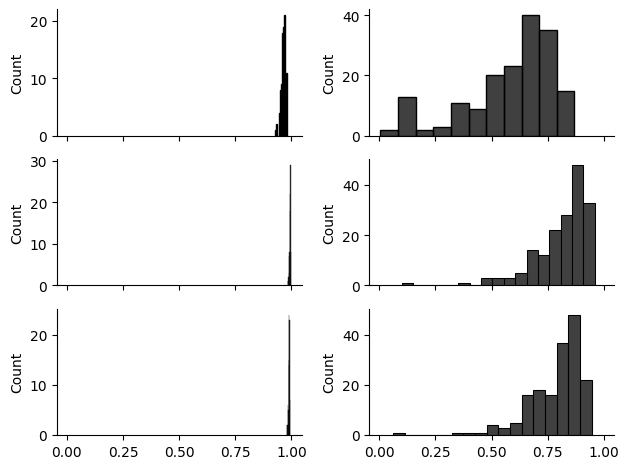

In [37]:
fig, ax = plt.subplots(3,2, sharex=True)

# Split
sns.histplot(fmri_corr_vals, stat='count', color='black', ax=ax[0,0])
sns.histplot(dmri_corr_vals, stat='count', color='black', ax=ax[1,0])
sns.histplot(resid_corr_vals, stat='count', color='black', ax=ax[2,0])

# Leave one out
sns.histplot(fmri_corr_loo_vals, stat='count', color='black', ax=ax[0,1])
sns.histplot(dmri_corr_loo_vals, stat='count', color='black', ax=ax[1,1])
sns.histplot(resid_corr_loo_vals, stat='count', color='black', ax=ax[2,1])

plt.tight_layout()
sns.despine()
plt.savefig(fig_path + f'rsfMRI-dMRI-resid_split_leave-one-out_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure 2

In [38]:
from matplotlib.cm import ScalarMappable

In [48]:
# Load data
#results_path = '/project/6050199/sudesnac/21_Codes/HumanBF-Parcellation/results'
resid_data = pd.read_csv(Gradc_results  + 'BF_atlas_weighted-resid_FG1-SG1.csv')

In [51]:
resid_data['sg1_fg1_resid'] = sg1_fg1_resid_squared

In [52]:
resid_data

,resid,varw_resid,r2w_resid,invr2w_resid,sigr2w_resid,siginvr2w_resid,labels,funcG1,diffG1,sg1_fg1_resid
0,0.092532,0.025630,0.005502,73.120337,0.005439,0.487399,2.0,-0.000632,0.219320,0.003324
1,0.084168,0.024526,0.005198,71.692603,0.005137,0.342200,2.0,0.017674,0.231589,0.001809
2,0.094203,0.027861,0.006260,72.386870,0.006191,0.402475,2.0,0.042986,0.231753,0.000298
3,0.078300,0.023781,0.005694,70.337194,0.005634,0.291306,2.0,-0.000140,0.221652,0.003337
4,0.094455,0.026358,0.005356,79.331832,0.005284,0.434374,2.0,0.006611,0.198926,0.002035
...,...,...,...,...,...,...,...,...,...,...
594,0.389318,0.151444,0.023772,173.301801,0.023543,2.649978,2.0,0.236503,-0.052365,0.062559
595,0.389883,0.149958,0.021505,180.901277,0.021256,2.686060,2.0,0.237930,-0.032154,0.060659
596,0.356002,0.138827,0.020417,171.558978,0.020188,2.310306,2.0,0.235959,0.014806,0.053875
597,0.389869,0.150802,0.019954,184.528988,0.019693,2.729426,2.0,0.244045,-0.002528,0.059879


In [63]:
pd.DataFrame(resid_data).to_csv(results_path + 'BF_atlas_resid_FG1-SG1.csv', index=False)

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


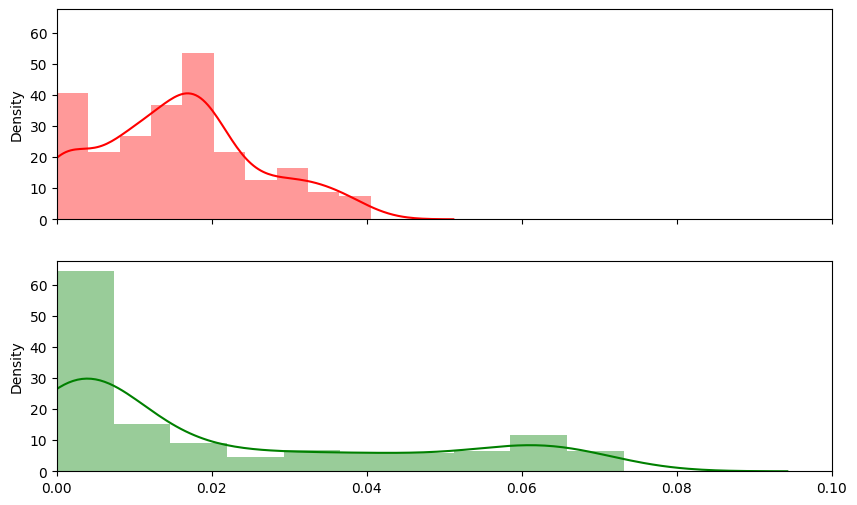

In [55]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10, 6))
colors = ['Red', 'Green']
for i in range(2):
    sns.distplot(
        x=resid_data[resid_data['labels']==i+1]["sg1_fg1_resid"],
        bins=10,
        color=colors[i],
        ax=ax[i]
    )
    
ax[0].set_xlim(0,0.1)

plt.savefig(fig_path + f'sg1-fg1-resid_atlas_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


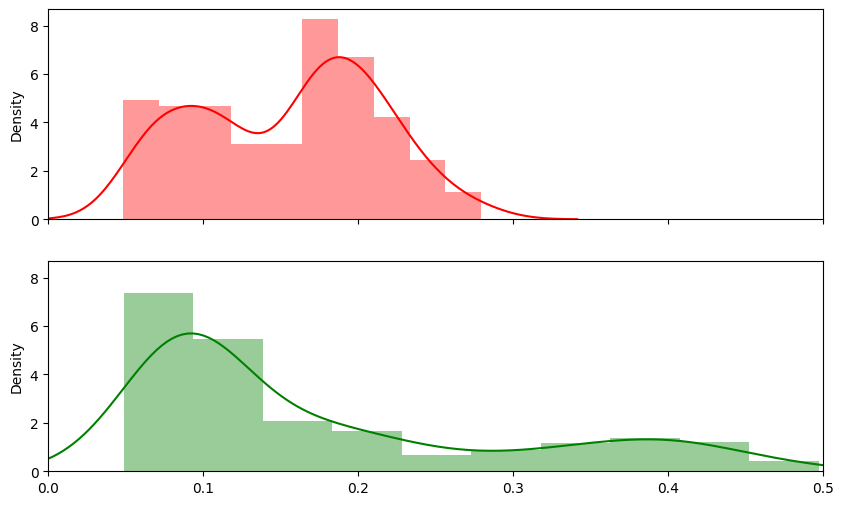

In [57]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10, 6))
colors = ['Red', 'Green']
for i in range(2):
    sns.distplot(
        x=resid_data[resid_data['labels']==i+1]["resid"],
        bins=10,
        color=colors[i],
        ax=ax[i]
    )
    
ax[0].set_xlim(0,0.5)

plt.savefig(fig_path + f'unweighted-avg-resid_atlas_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


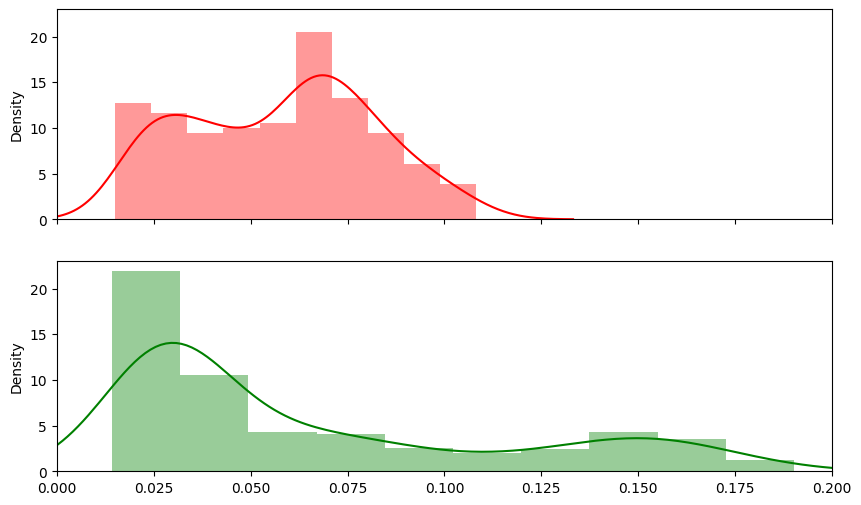

In [59]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10, 6))
colors = ['Red', 'Green']
for i in range(2):
    sns.distplot(
        x=resid_data[resid_data['labels']==i+1]["varw_resid"],
        bins=10,
        color=colors[i],
        ax=ax[i]
    )
    
ax[0].set_xlim(0,0.2)

plt.savefig(fig_path + f'variance-weighted-resid_atlas_dist-plot.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure 4

In [61]:
# Load data
ctx_data = pd.read_csv(Conn_results + 'parc_rescaled_all_data.csv')

feobv     = ctx_data['Michigan_FEOBV'].values
geodesic  = ctx_data['Geodesic'].values
myelin    = ctx_data['Myelin'].values
dmri_conn = ctx_data['structural'].values
fmri_conn = ctx_data['functional'].values

s_f_tethering = pd.read_csv(
    Gradc_results + 'Gradient-weighted-map_Struct_vs_Func_linear_least-squares_regression_s6-f4_residuals-squared.csv')['(0, 0)'].values

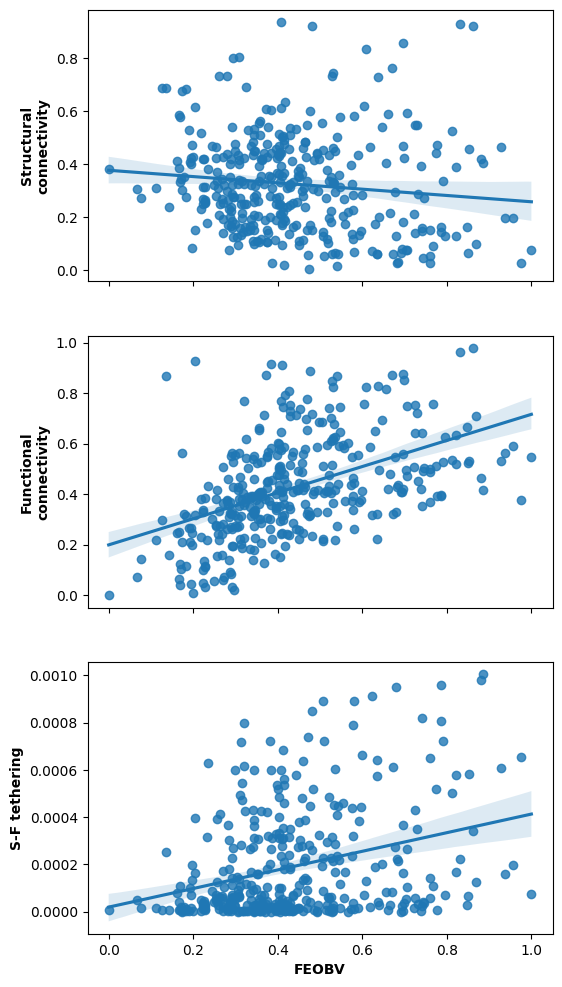

In [62]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(6, 12))

sns.regplot(
    x=feobv,
    y=dmri_conn,
    ax=ax[0]
)
ax[0].set_ylabel('Structural\nconnectivity', weight='bold')

sns.regplot(
    x=feobv,
    y=fmri_conn,
    ax=ax[1]
)
ax[1].set_ylabel('Functional\nconnectivity', weight='bold')

sns.regplot(
    x=feobv,
    y=np.abs(s_f_tethering),
    ax=ax[2]
)

ax[2].set_xlabel('FEOBV', weight='bold')
ax[2].set_ylabel('S-F tethering', weight='bold')

plt.savefig(fig_path + f'Michigan-FEOBV_conn-data.png', dpi=300, bbox_inches='tight')
plt.show()